# Practica 3 - Trabajo Final


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import seaborn as sns
import daft
import pymc as pm
import arviz as az

## Dataset / Preprocesamiento


In [2]:
df = pd.read_csv(r"../practica3/positivos_por_tests.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Laboratorio  14 non-null     object 
 1   muestra      14 non-null     int64  
 2   20par-DTU1   14 non-null     float64
 3   20par-DTU2   14 non-null     float64
 4   20par-DTU6   14 non-null     float64
 5   50par-DTU1   14 non-null     float64
 6   50par-DTU2   14 non-null     int64  
 7   50par-DTU6   14 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.0+ KB


In [4]:
df.head()

,Laboratorio,muestra,20par-DTU1,20par-DTU2,20par-DTU6,50par-DTU1,50par-DTU2,50par-DTU6
0,AS,3,66.666667,100.0,100.0,100.0,100,100.0
1,VH,3,100.000000,100.0,100.0,100.0,100,100.0
2,CB,3,100.000000,100.0,100.0,100.0,100,100.0
3,SC,3,100.000000,100.0,100.0,100.0,100,100.0
4,SU-1,3,33.333333,100.0,100.0,100.0,100,100.0


In [5]:
# Convertir de formato ancho a largo
df_long = pd.melt(
    df,
    id_vars=["Laboratorio", "muestra"],
    value_vars=[col for col in df.columns if "par-" in col],
    var_name="CondicionTest",
    value_name="Porcentaje"
)

# Separar en columnas: Concentración y Test
df_long[["Concentracion", "Test"]] = df_long["CondicionTest"].str.extract(r"(\d+par)-(.+)")

# Calcular número de positivos (suponiendo que cada test se aplicó sobre 3 muestras)
df_long["Positivos"] = (df_long["Porcentaje"] / 100 * 3).round().astype(int)

# Calcular número de negativos
df_long["Negativos"] = 3 - df_long["Positivos"]


df_long["Concentracion"] = pd.Categorical(df_long["Concentracion"], categories=["20par", "50par"], ordered=True)
df_preprocessed = df_long[["Laboratorio", "Test", "Concentracion", "Positivos", "Negativos"]].copy()

df_preprocessed.head()

,Laboratorio,Test,Concentracion,Positivos,Negativos
0,AS,DTU1,20par,2,1
1,VH,DTU1,20par,3,0
2,CB,DTU1,20par,3,0
3,SC,DTU1,20par,3,0
4,SU-1,DTU1,20par,1,2


In [6]:
prob_positivos = df_long["Porcentaje"].mean() / 100
print(
    f"Probabilidad promedio de positivos (integrando sobre todas las condiciones): {prob_positivos:.3f}"
)

Probabilidad promedio de positivos (integrando sobre todas las condiciones): 0.857


## Especificacion del modelo causal


- ### Variables:

<div style="text-align: center;">

$ t \in \{1,2,3\} $ el índice de test (DTU1, DTU2, DTU6)

$ c \in \{0,1\} $ la concentración (0 = baja, 1 = alta)

$ j \in \{1,\dots,14\} $ el laboratorio

$ y_{jtc} $ el número de positivos observados

</div>

- ### Modelo:

Se modelan el numero de positivos observados como una binomial con N=3 fijo y probabilidad de exito $p_{jtc}$ que depende de la concentración, el test y el laboratorio. La probabilidad $p_{jtc}$ depende de $\alpha_{t,c}$ la sensibilidad del test para un dado nivel de concentración y $\beta_j$ la probabilidad de error del laboratorio.

<div style="text-align: center;">

$y_{jtc} \sim \text{Binomial}(3, p_{jtc})$

$p_{jtc} = \alpha_{t,c}   (1 - \beta_j )
$

</div>

- ### Priors:

Prior levemente informativo para la sensibilidad del test con media ~0.7

<div style="text-align: center;">

$\alpha_{t,c} \sim \mathcal{B}(3, 1.2)
$

</div>

Prior levemente informativo para la probabilidad de error del laboratorio con media ~0.2

<div style="text-align: center;">

$\beta_j \sim \mathcal{B}(2, 6)
$

</div>



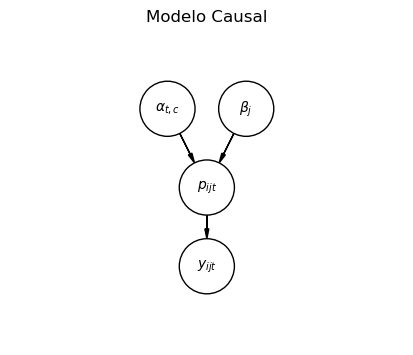

In [7]:
pgm = daft.PGM([5, 4], origin=[0, 0], node_unit=1.4)

pgm.add_node("alpha", r"$\alpha_{t,c}$", 2, 3)   # sensibilidad por test y concentración
pgm.add_node("beta", r"$\beta_{j}$", 3, 3)       # efecto laboratorio
pgm.add_node("p", r"$p_{ijt}$", 2.5, 2)          # probabilidad
pgm.add_node("y", r"$y_{ijt}$", 2.5, 1)          # observación binomial


pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("p", "y")

pgm.render()
plt.title("Modelo Causal")
plt.show()


In [8]:
test_categories = df_preprocessed["Test"].astype("category").cat.categories.tolist()
conc_categories = (
    df_preprocessed["Concentracion"].astype("category").cat.categories.tolist()
)
lab_categories = (
    df_preprocessed["Laboratorio"].astype("category").cat.categories.tolist()
)


coords = {
    "test": test_categories,
    "concentration": conc_categories,
    "lab": lab_categories,
    "obs_id": np.arange(len(df_preprocessed)),
}


df = df_preprocessed.copy()
df["test_idx"] = df["Test"].astype("category").cat.codes
df["conc_idx"] = df["Concentracion"].astype("category").cat.codes
df["lab_idx"] = df["Laboratorio"].astype("category").cat.codes

n_total = 3

with pm.Model(coords=coords) as model_explicit:

    # Indices 
    test_idx = pm.Data("test_idx", df["test_idx"].values, dims="obs_id")
    conc_idx = pm.Data("conc_idx", df["conc_idx"].values, dims="obs_id")
    lab_idx = pm.Data("lab_idx", df["lab_idx"].values, dims="obs_id")

    # Priors
    sens = pm.Beta("Alpha", alpha=3, beta=1.2, dims=("test", "concentration"))
    err_lab = pm.Beta("Beta", alpha=2, beta=6, dims="lab")

    # Prob de resultado positivo
    p = pm.Deterministic(
        "p", sens[test_idx, conc_idx] * (1 - err_lab[lab_idx]), dims="obs_id"
    )

    # Likelihood
    y_obs = pm.Binomial(
        "y_obs", n=n_total, p=p, observed=df["Positivos"].values, dims="obs_id"
    )

    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [9]:
az.summary(trace, var_names=["Alpha", "Beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Alpha[DTU1, 20par]",0.802,0.079,0.656,0.951,0.001,0.001,5060.0,2804.0,1.0
"Alpha[DTU1, 50par]",0.970,0.027,0.922,1.000,0.000,0.000,7416.0,3888.0,1.0
"Alpha[DTU2, 20par]",0.956,0.038,0.887,1.000,0.000,0.001,7721.0,4345.0,1.0
"Alpha[DTU2, 50par]",0.968,0.028,0.917,1.000,0.000,0.000,7087.0,3798.0,1.0
"Alpha[DTU6, 20par]",0.921,0.053,0.828,1.000,0.001,0.001,6284.0,3326.0,1.0
"Alpha[DTU6, 50par]",0.970,0.026,0.922,1.000,0.000,0.000,7702.0,3666.0,1.0
Beta[AS],0.089,0.057,0.004,0.193,0.001,0.001,7984.0,4173.0,1.0
Beta[BA],0.127,0.071,0.012,0.258,0.001,0.001,7559.0,4153.0,1.0
Beta[CB],0.077,0.051,0.003,0.169,0.001,0.001,7558.0,4393.0,1.0
Beta[SC],0.076,0.050,0.002,0.166,0.000,0.001,8148.0,4610.0,1.0


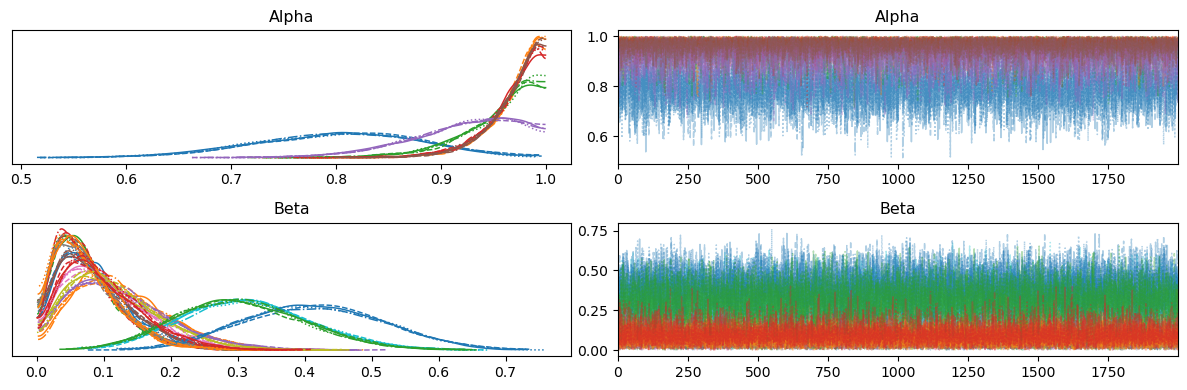

In [10]:
az.plot_trace(trace, var_names=["Alpha", "Beta"])
plt.tight_layout()

## Desempeño de los laboratorios


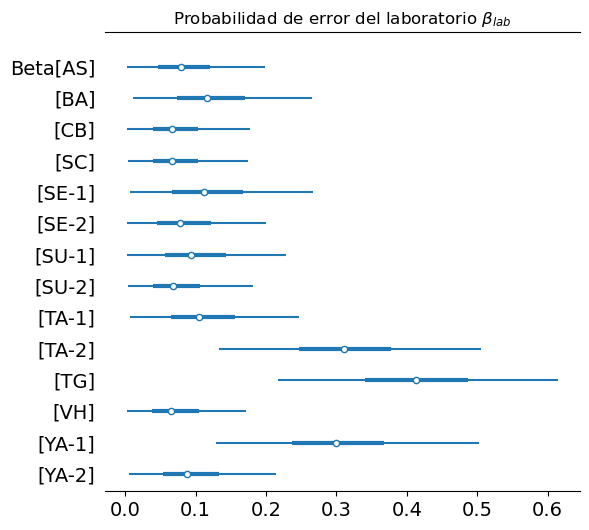

In [11]:
az.plot_forest(
    trace,
    var_names=["Beta"],
    combined=True,
    hdi_prob=0.95,
    kind="forestplot",
)

plt.title("Probabilidad de error del laboratorio $\\beta_{lab}$")
plt.tight_layout()

- Se observa que para la mayor parte de los laboratorios el HDI contiene a 0 y es compatible con una tasa baja o nula de errores. 
- Para los laboratorios TA-2, TG y YA-1 la tasa de error es significativamente superior al resto de los laboratorios.

## Desempeño de los tests

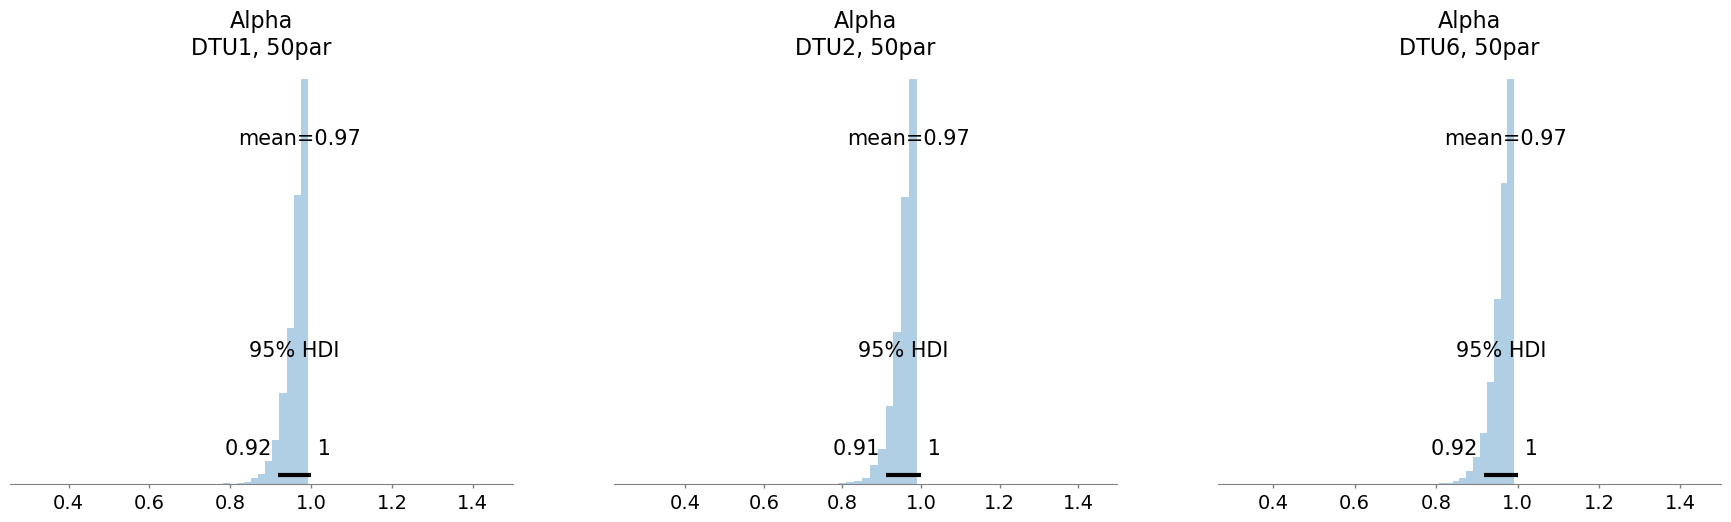

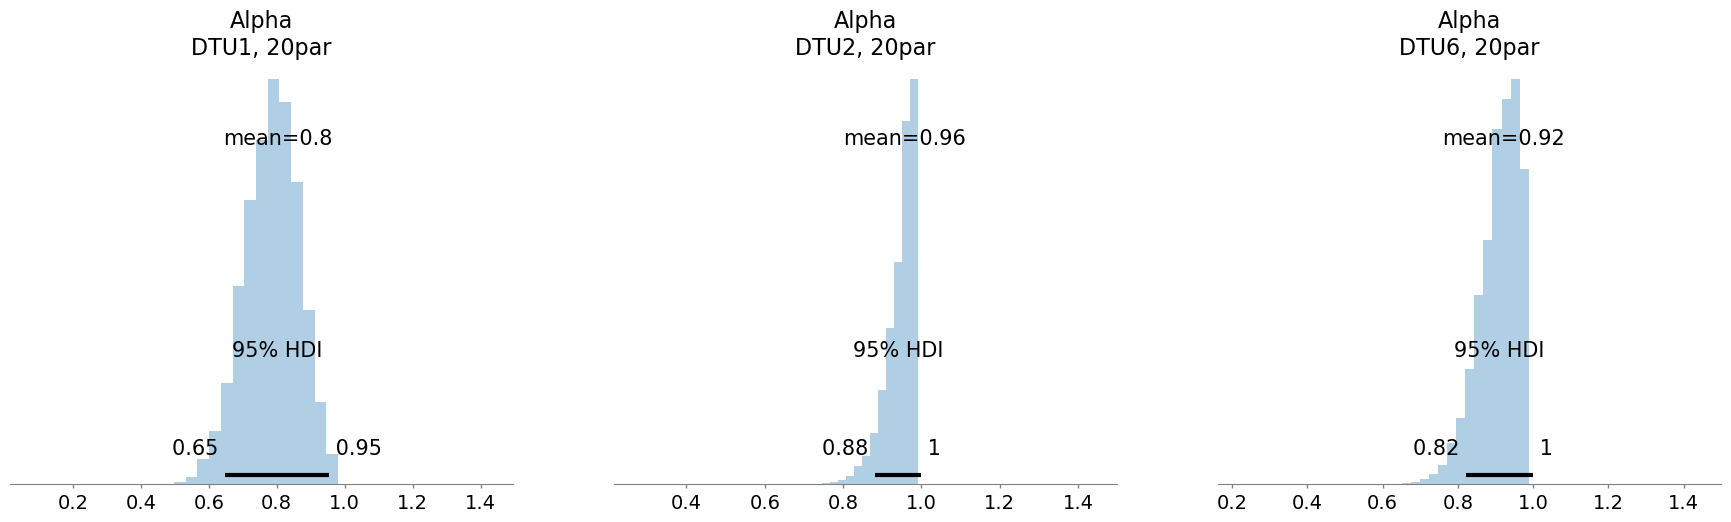

In [12]:
az.plot_posterior(
    trace,
    var_names=["Alpha"],
    coords={"concentration": ["50par"]},
    kind="hist",
    hdi_prob=0.95,
    point_estimate="mean",
)

az.plot_posterior(
    trace,
    var_names=["Alpha"],
    coords={"concentration": ["20par"]},
    kind="hist",
    hdi_prob=0.95,
    point_estimate="mean",
)

plt.show()

* Se observa que para alta concentracion la sensibilidad de los tests es similar.
* Para baja concentracion se pueden observar diferencias entre los tests, siendo DTU1 el que tiene peor sensibilidad.

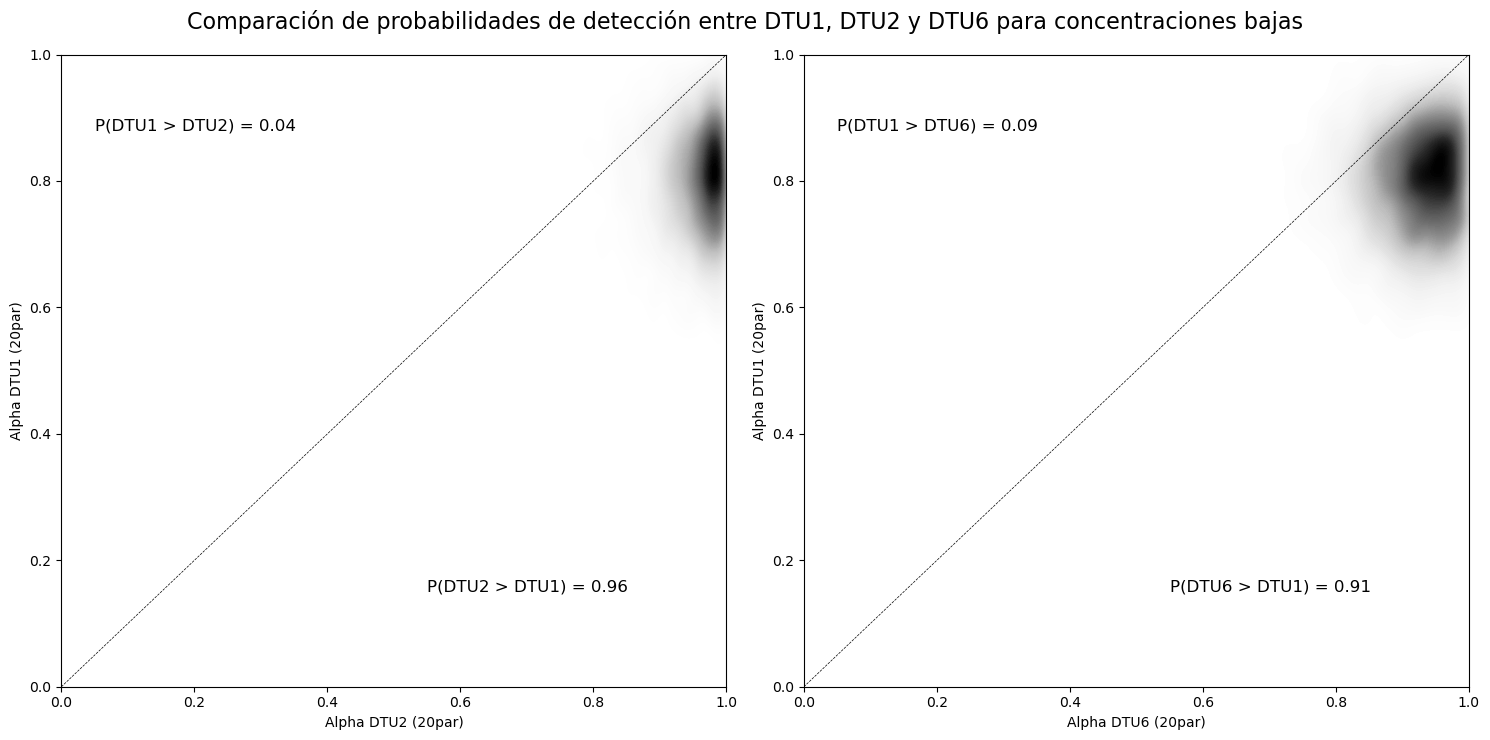

In [45]:
alpha_samples = trace.posterior["Alpha"]
alpha_dtu1_20par = alpha_samples.sel(test="DTU1", concentration="20par").values.flatten()
alpha_dtu2_20par = alpha_samples.sel(test="DTU2", concentration="20par").values.flatten()
alpha_dtu6_20par = alpha_samples.sel(test="DTU6", concentration="20par").values.flatten()


fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))

# DTU2 VS DTU1
sns.kdeplot(
    x=alpha_dtu2_20par,
    y=alpha_dtu1_20par,
    fill=True,
    cmap="Greys",
    thresh=0,
    levels=100,
    ax=axs[0])


axs[0].plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=0.5)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_xlabel("Alpha DTU2 (20par)")
axs[0].set_ylabel("Alpha DTU1 (20par)")

# Calcular probabilidades
prob_dtu2_gt_dtu1 = np.mean(alpha_dtu2_20par > alpha_dtu1_20par)
prob_dtu1_gt_dtu2 = np.mean(alpha_dtu1_20par > alpha_dtu2_20par)

# Mostrar en el gráfico
axs[0].text(
    0.55, 0.15,
    f"P(DTU2 > DTU1) = {prob_dtu2_gt_dtu1:.2f}",
    transform=axs[0].transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)
axs[0].text(
    0.05, 0.88,
    f"P(DTU1 > DTU2) = {prob_dtu1_gt_dtu2:.2f}",
    transform=axs[0].transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

## DTU6 VS DTU1
sns.kdeplot(
    x=alpha_dtu6_20par,
    y=alpha_dtu1_20par,
    fill=True,
    cmap="Greys",
    thresh=0,
    levels=100,
    ax=axs[1])

axs[1].plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=0.5)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel("Alpha DTU6 (20par)")
axs[1].set_ylabel("Alpha DTU1 (20par)")
# Calcular probabilidades
prob_dtu6_gt_dtu1 = np.mean(alpha_dtu6_20par > alpha_dtu1_20par)
prob_dtu1_gt_dtu6 = np.mean(alpha_dtu1_20par > alpha_dtu6_20par)
axs[1].text(
    0.55, 0.15,
    f"P(DTU6 > DTU1) = {prob_dtu6_gt_dtu1:.2f}",
    transform=axs[1].transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

axs[1].text(
    0.05, 0.88,
    f"P(DTU1 > DTU6) = {prob_dtu1_gt_dtu6:.2f}",
    transform=axs[1].transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)


plt.suptitle("Comparación de probabilidades de detección entre DTU1, DTU2 y DTU6 para concentraciones bajas", fontsize=16)
plt.tight_layout()
plt.show()